In [1]:
import os
import json
import requests
from typing import Dict, List, Any, TypedDict, Optional
from dataclasses import dataclass, asdict
from datetime import datetime, timedelta
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain.schema import SystemMessage,HumanMessage
from langgraph.graph import StateGraph, START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from IPython.display import Image,display
from langgraph.checkpoint.memory import MemorySaver

In [2]:
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]= os.getenv("GROQ_API_KEY")
os.environ["GOOGLE_API_KEY"]= os.getenv("GOOGLE_API_KEY")

os.environ["LANGCHAIN_API_KEY"]= os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"]= os.getenv("LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_TRACING_V2"]= os.getenv("LANGCHAIN_TRACING_V2")
os.environ["TAVILY_API_KEY"]= os.getenv("TAVILY_API_KEY")

# Define our LLM
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model = "gpt-4o-mini")

In [3]:
@dataclass
class TravelRequest:
    """User's travel requirements"""
    start_location: str
    destination: str
    num_people: int
    start_date: str
    duration_days: int
    budget: float
    preferences: Dict[str, Any] = None

@dataclass
class FlightOption:
    """Flight option details"""
    airline: str
    departure_time: str
    arrival_time: str
    price_per_person: float
    duration: str
    flight_number: str = ""
    
@dataclass
class HotelOption:
    """Hotel option details"""
    name: str
    price_per_night: float
    rating: float
    location: str
    amenities: List[str]
    
@dataclass
class DayItinerary:
    """Day-wise itinerary"""
    day: int
    date: str
    activities: List[str]
    estimated_cost: float
    meals: List[str]

@dataclass
class TravelPlan:
    """Complete travel plan"""
    flights: Dict[str, List[FlightOption]]  # outbound, return
    hotels: List[HotelOption]
    itinerary: List[DayItinerary]
    total_cost: float
    cost_breakdown: Dict[str, float]

@dataclass
class BookingDetails:
    """Booking confirmation details"""
    flight_bookings: List[Dict]
    hotel_bookings: List[Dict]
    payment_method: str = ""
    payment_confirmed: bool = False

class TravelState(TypedDict):
    """State shared between all travel agents"""
    travel_request: TravelRequest
    travel_plan: Optional[TravelPlan]
    booking_details: Optional[BookingDetails]
    messages: List[str]
    next_agent: str
    needs_human_input: bool
    human_feedback: str
    plan_approved: bool
    budget_exceeded: bool
    iteration_count: int
    booking_confirmed: bool

In [4]:
class InputProcessingAgent:
    """Agent to process and validate user travel requirements"""
    
    def __init__(self, llm):
        self.llm = llm
        self.name = "Input Processing Agent"
    
    def process(self, state: TravelState) -> TravelState:
        travel_request = state["travel_request"]
        
        # Validate input data
        validation_prompt = f"""
        Validate this travel request and identify any missing or problematic information:
        
        Start Location: {travel_request.start_location}
        Destination: {travel_request.destination}
        Number of People: {travel_request.num_people}
        Start Date: {travel_request.start_date}
        Duration: {travel_request.duration_days} days
        Budget: ${travel_request.budget}
        
        Check for:
        1. Valid locations (real cities/airports)
        2. Reasonable dates (not in the past)
        3. Realistic budget for the trip
        4. Valid number of people
        
        Respond in JSON format:
        {{
            "valid": true/false,
            "issues": ["list of any issues found"],
            "suggestions": ["suggestions to fix issues"],
            "processed_request": {{
                "start_location": "standardized location",
                "destination": "standardized destination",
                "start_date": "YYYY-MM-DD format",
                "budget_per_person": calculated_amount
            }}
        }}
        """
        
        response = self.llm.invoke([SystemMessage(content=validation_prompt)])
        
        try:
            result = json.loads(response.content)
            
            if result["valid"]:
                # Update request with processed data
                processed = result["processed_request"]
                travel_request.start_location = processed.get("start_location", travel_request.start_location)
                travel_request.destination = processed.get("destination", travel_request.destination)
                travel_request.start_date = processed.get("start_date", travel_request.start_date)
                
                state["messages"].append(f"[{self.name}] Travel request validated successfully")
                state["next_agent"] = "flight_search"
            else:
                state["messages"].append(f"[{self.name}] Validation issues found: {', '.join(result['issues'])}")
                state["needs_human_input"] = True
                state["human_feedback"] = f"Please fix these issues: {'; '.join(result['suggestions'])}"
                state["next_agent"] = "confirmation"
                
        except json.JSONDecodeError:
            state["messages"].append(f"[{self.name}] Error validating request - proceeding with caution")
            state["next_agent"] = "flight_search"
        
        return state

class FlightSearchAgent:
    """Agent to search and recommend flight options"""
    
    def __init__(self, llm):
        self.llm = llm
        self.name = "Flight Search Agent"
    
    def process(self, state: TravelState) -> TravelState:
        travel_request = state["travel_request"]
        
        # Simulate flight search (in real implementation, you'd use flight APIs)
        flight_prompt = f"""
        Find flight options for this trip:
        From: {travel_request.start_location}
        To: {travel_request.destination}
        Date: {travel_request.start_date}
        Passengers: {travel_request.num_people}
        Budget per person: ${travel_request.budget / travel_request.num_people / 2} (assuming 50% of budget for flights)
        
        Provide 3 outbound and 3 return flight options with realistic airlines, times, and prices.
        
        Respond in JSON format:
        {{
            "outbound_flights": [
                {{
                    "airline": "airline name",
                    "departure_time": "HH:MM",
                    "arrival_time": "HH:MM",
                    "price_per_person": price,
                    "duration": "Xh YYm",
                    "flight_number": "XX123"
                }}
            ],
            "return_flights": [similar format],
            "recommendations": "brief explanation of best options"
        }}
        """
        
        response = self.llm.invoke([SystemMessage(content=flight_prompt)])
        
        try:
            result = json.loads(response.content)
            
            # Convert to FlightOption objects
            outbound_flights = [
                FlightOption(**flight) for flight in result.get("outbound_flights", [])
            ]
            return_flights = [
                FlightOption(**flight) for flight in result.get("return_flights", [])
            ]
            
            # Initialize travel plan if not exists
            if not state["travel_plan"]:
                state["travel_plan"] = TravelPlan(
                    flights={"outbound": outbound_flights, "return": return_flights},
                    hotels=[],
                    itinerary=[],
                    total_cost=0,
                    cost_breakdown={}
                )
            else:
                state["travel_plan"].flights = {"outbound": outbound_flights, "return": return_flights}
            
            state["messages"].append(f"[{self.name}] Found {len(outbound_flights)} outbound and {len(return_flights)} return flight options")
            state["next_agent"] = "accommodation"
            
        except json.JSONDecodeError:
            state["messages"].append(f"[{self.name}] Error searching flights - using sample data")
            # Fallback with sample data
            sample_flights = [
                FlightOption("Delta Airlines", "08:00", "12:00", 350, "4h 0m", "DL123"),
                FlightOption("American Airlines", "14:00", "18:00", 320, "4h 0m", "AA456")
            ]
            
            if not state["travel_plan"]:
                state["travel_plan"] = TravelPlan(
                    flights={"outbound": sample_flights, "return": sample_flights},
                    hotels=[], itinerary=[], total_cost=0, cost_breakdown={}
                )
            
            state["next_agent"] = "accommodation"
        
        return state

class AccommodationAgent:
    """Agent to search and recommend hotel options"""
    
    def __init__(self, llm):
        self.llm = llm
        self.name = "Accommodation Agent"
    
    def process(self, state: TravelState) -> TravelState:
        travel_request = state["travel_request"]
        
        hotel_prompt = f"""
        Find hotel recommendations for:
        Destination: {travel_request.destination}
        Check-in: {travel_request.start_date}
        Duration: {travel_request.duration_days} nights
        Guests: {travel_request.num_people}
        Budget per night: ${(travel_request.budget * 0.4) / travel_request.duration_days} (assuming 40% of budget for accommodation)
        
        Provide 3-4 hotel options with different price ranges.
        
        Respond in JSON format:
        {{
            "hotels": [
                {{
                    "name": "hotel name",
                    "price_per_night": price,
                    "rating": rating_out_of_5,
                    "location": "area/district",
                    "amenities": ["wifi", "pool", "gym", etc]
                }}
            ],
            "recommendations": "brief explanation of best options"
        }}
        """
        
        response = self.llm.invoke([SystemMessage(content=hotel_prompt)])
        
        try:
            result = json.loads(response.content)
            
            hotels = [HotelOption(**hotel) for hotel in result.get("hotels", [])]
            state["travel_plan"].hotels = hotels
            
            state["messages"].append(f"[{self.name}] Found {len(hotels)} hotel options")
            state["next_agent"] = "itinerary"
            
        except json.JSONDecodeError:
            # Fallback with sample data
            sample_hotels = [
                HotelOption("Grand Plaza Hotel", 120, 4.2, "Downtown", ["WiFi", "Pool", "Gym"]),
                HotelOption("Budget Inn", 80, 3.5, "City Center", ["WiFi", "Breakfast"])
            ]
            state["travel_plan"].hotels = sample_hotels
            state["messages"].append(f"[{self.name}] Using sample hotel data")
            state["next_agent"] = "itinerary"
        
        return state

class ItineraryAgent:
    """Agent to create day-wise itinerary with sightseeing and dining"""
    
    def __init__(self, llm):
        self.llm = llm
        self.name = "Itinerary Agent"
    
    def process(self, state: TravelState) -> TravelState:
        travel_request = state["travel_request"]
        
        itinerary_prompt = f"""
        Create a {travel_request.duration_days}-day itinerary for:
        Destination: {travel_request.destination}
        Start Date: {travel_request.start_date}
        Number of People: {travel_request.num_people}
        Daily Budget for activities/food: ${(travel_request.budget * 0.3) / travel_request.duration_days}
        
        For each day, include:
        - 2-3 main attractions/activities
        - Recommended meals (breakfast, lunch, dinner locations)
        - Estimated costs
        
        Respond in JSON format:
        {{
            "itinerary": [
                {{
                    "day": 1,
                    "date": "YYYY-MM-DD",
                    "activities": ["activity 1", "activity 2", "activity 3"],
                    "estimated_cost": daily_cost,
                    "meals": ["breakfast place", "lunch place", "dinner place"]
                }}
            ]
        }}
        """
        
        response = self.llm.invoke([SystemMessage(content=itinerary_prompt)])
        
        try:
            result = json.loads(response.content)
            
            itinerary = [DayItinerary(**day) for day in result.get("itinerary", [])]
            state["travel_plan"].itinerary = itinerary
            
            state["messages"].append(f"[{self.name}] Created {len(itinerary)}-day itinerary")
            state["next_agent"] = "budget_optimizer"
            
        except json.JSONDecodeError:
            # Create basic itinerary
            start_date = datetime.strptime(travel_request.start_date, "%Y-%m-%d")
            sample_itinerary = []
            
            for i in range(travel_request.duration_days):
                day_date = start_date + timedelta(days=i)
                sample_itinerary.append(
                    DayItinerary(
                        day=i+1,
                        date=day_date.strftime("%Y-%m-%d"),
                        activities=[f"Activity {i+1}", f"Sightseeing {i+1}"],
                        estimated_cost=100,
                        meals=["Local Cafe", "Popular Restaurant", "Street Food"]
                    )
                )
            
            state["travel_plan"].itinerary = sample_itinerary
            state["messages"].append(f"[{self.name}] Created basic itinerary")
            state["next_agent"] = "budget_optimizer"
        
        return state

class BudgetOptimizerAgent:
    """Agent to ensure the plan stays within budget"""
    
    def __init__(self, llm):
        self.llm = llm
        self.name = "Budget Optimizer Agent"
    
    def process(self, state: TravelState) -> TravelState:
        travel_request = state["travel_request"]
        travel_plan = state["travel_plan"]
        
        # Calculate total costs
        flight_cost = 0
        if travel_plan.flights.get("outbound"):
            flight_cost += min(f.price_per_person for f in travel_plan.flights["outbound"]) * travel_request.num_people
        if travel_plan.flights.get("return"):
            flight_cost += min(f.price_per_person for f in travel_plan.flights["return"]) * travel_request.num_people
        
        hotel_cost = 0
        if travel_plan.hotels:
            cheapest_hotel = min(travel_plan.hotels, key=lambda h: h.price_per_night)
            hotel_cost = cheapest_hotel.price_per_night * travel_request.duration_days
        
        activity_cost = sum(day.estimated_cost for day in travel_plan.itinerary)
        
        total_cost = flight_cost + hotel_cost + activity_cost
        
        # Update cost breakdown
        travel_plan.cost_breakdown = {
            "flights": flight_cost,
            "accommodation": hotel_cost,
            "activities_food": activity_cost
        }
        travel_plan.total_cost = total_cost
        
        budget_exceeded = total_cost > travel_request.budget
        state["budget_exceeded"] = budget_exceeded
        
        if budget_exceeded and state["iteration_count"] < 3:
            # Optimize the plan
            optimize_prompt = f"""
            The current travel plan exceeds budget:
            Budget: ${travel_request.budget}
            Current Total: ${total_cost}
            Overage: ${total_cost - travel_request.budget}
            
            Breakdown:
            - Flights: ${flight_cost}
            - Hotels: ${hotel_cost}
            - Activities/Food: ${activity_cost}
            
            Suggest optimizations to reduce costs while maintaining trip quality:
            
            Respond in JSON format:
            {{
                "optimizations": [
                    {{
                        "category": "flights/hotels/activities",
                        "suggestion": "specific suggestion",
                        "savings": estimated_savings
                    }}
                ],
                "revised_daily_budget": new_daily_budget_for_activities
            }}
            """
            
            response = self.llm.invoke([SystemMessage(content=optimize_prompt)])
            
            try:
                result = json.loads(response.content)
                optimizations = result.get("optimizations", [])
                
                # Apply optimizations (simplified)
                if result.get("revised_daily_budget"):
                    for day in travel_plan.itinerary:
                        day.estimated_cost = min(day.estimated_cost, result["revised_daily_budget"])
                
                state["messages"].append(f"[{self.name}] Applied {len(optimizations)} budget optimizations")
                state["iteration_count"] += 1
                state["next_agent"] = "budget_optimizer"  # Re-check budget
                
            except json.JSONDecodeError:
                state["messages"].append(f"[{self.name}] Budget exceeded by ${total_cost - travel_request.budget:.2f}")
                state["next_agent"] = "confirmation"
        else:
            if budget_exceeded:
                state["messages"].append(f"[{self.name}] Unable to optimize further - ${total_cost - travel_request.budget:.2f} over budget")
            else:
                state["messages"].append(f"[{self.name}] Plan within budget - Total: ${total_cost:.2f}")
            
            state["next_agent"] = "confirmation"
        
        return state

class ConfirmationAgent:
    """Agent to get human confirmation and handle feedback"""
    
    def __init__(self, llm):
        self.llm = llm
        self.name = "Confirmation Agent"
    
    def process(self, state: TravelState) -> TravelState:
        travel_plan = state["travel_plan"]
        travel_request = state["travel_request"]
        
        # Present plan for confirmation
        if not state["needs_human_input"]:
            confirmation_prompt = f"""
            TRAVEL PLAN READY FOR CONFIRMATION
            
            Total Cost: ${travel_plan.total_cost:.2f} (Budget: ${travel_request.budget})
            
            FLIGHTS:
            Outbound Options: {len(travel_plan.flights.get('outbound', []))} available
            Return Options: {len(travel_plan.flights.get('return', []))} available
            
            ACCOMMODATION:
            {len(travel_plan.hotels)} hotel options available
            
            ITINERARY:
            {len(travel_plan.itinerary)} days planned
            
            Please confirm:
            1. Approve the plan as-is
            2. Request specific changes
            3. Select preferred flights and hotels
            
            Type 'APPROVE' to proceed with booking, or provide specific feedback.
            """
            
            state["messages"].append(f"[{self.name}] Plan ready for human confirmation")
            state["needs_human_input"] = True
            
            # Simulate human input for demo
            state["human_feedback"] = "APPROVE"  # In real implementation, this would be actual user input
            
        # Process human feedback
        if state["human_feedback"]:
            if state["human_feedback"].upper() == "APPROVE":
                state["plan_approved"] = True
                state["next_agent"] = "booking"
                state["messages"].append(f"[{self.name}] Plan approved by user")
            else:
                # Handle specific feedback (simplified for demo)
                state["messages"].append(f"[{self.name}] Processing user feedback: {state['human_feedback']}")
                state["next_agent"] = "itinerary"  # Loop back to modify plan
            
            state["needs_human_input"] = False
            state["human_feedback"] = ""
        
        return state

class BookingAgent:
    """Agent to handle actual flight and hotel bookings"""
    
    def __init__(self, llm):
        self.llm = llm
        self.name = "Booking Agent"
    
    def process(self, state: TravelState) -> TravelState:
        travel_plan = state["travel_plan"]
        travel_request = state["travel_request"]
        
        if not state["plan_approved"]:
            state["messages"].append(f"[{self.name}] Cannot proceed - plan not approved")
            return state
        
        # Simulate booking process
        booking_prompt = f"""
        Process bookings for approved travel plan:
        
        Passengers: {travel_request.num_people}
        Destination: {travel_request.destination}
        Duration: {travel_request.duration_days} days
        
        Simulate booking confirmations for:
        1. Best flight options (outbound + return)
        2. Recommended hotel
        
        Respond in JSON format:
        {{
            "flight_booking": {{
                "confirmation_number": "FL123456",
                "outbound_flight": "flight details",
                "return_flight": "flight details",
                "total_cost": flight_cost
            }},
            "hotel_booking": {{
                "confirmation_number": "HT789012",
                "hotel_name": "selected hotel",
                "check_in": "date",
                "check_out": "date",
                "total_cost": hotel_cost
            }},
            "booking_successful": true/false
        }}
        """
        
        response = self.llm.invoke([SystemMessage(content=booking_prompt)])
        
        try:
            result = json.loads(response.content)
            
            if result.get("booking_successful", True):
                booking_details = BookingDetails(
                    flight_bookings=[result.get("flight_booking", {})],
                    hotel_bookings=[result.get("hotel_booking", {})],
                    payment_confirmed=True
                )
                
                state["booking_details"] = booking_details
                state["booking_confirmed"] = True
                state["messages"].append(f"[{self.name}] Bookings confirmed successfully!")
                
            else:
                state["messages"].append(f"[{self.name}] Booking failed - please try again")
                state["next_agent"] = "confirmation"
                
        except json.JSONDecodeError:
            # Simulate successful booking
            booking_details = BookingDetails(
                flight_bookings=[{"confirmation_number": "FL123456", "status": "confirmed"}],
                hotel_bookings=[{"confirmation_number": "HT789012", "status": "confirmed"}],
                payment_confirmed=True
            )
            
            state["booking_details"] = booking_details
            state["booking_confirmed"] = True
            state["messages"].append(f"[{self.name}] Bookings completed (simulated)")
        
        return state

In [ ]:
def create_travel_workflow():
    """Create the LangGraph workflow for travel planning"""
    
    # Initialize agents
    input_agent = InputProcessingAgent(llm)
    flight_agent = FlightSearchAgent(llm)
    accommodation_agent = AccommodationAgent(llm)
    itinerary_agent = ItineraryAgent(llm)
    budget_agent = BudgetOptimizerAgent(llm)
    confirmation_agent = ConfirmationAgent(llm)
    booking_agent = BookingAgent(llm)
    
    # Create workflow
    workflow = StateGraph(TravelState)
    
    # Add agent nodes
    workflow.add_node("input_processing", input_agent.process)
    workflow.add_node("flight_search", flight_agent.process)
    workflow.add_node("accommodation", accommodation_agent.process)
    workflow.add_node("itinerary", itinerary_agent.process)
    workflow.add_node("budget_optimizer", budget_agent.process)
    workflow.add_node("confirmation", confirmation_agent.process)
    workflow.add_node("booking", booking_agent.process)
    
    # Set entry point
    workflow.set_entry_point("input_processing")
    
    # Define routing logic
    def route_from_input(state: TravelState) -> str:
        if state["needs_human_input"]:
            return "confirmation"
        return state["next_agent"]
    
    def route_from_confirmation(state: TravelState) -> str:
        if state["booking_confirmed"]:
            return END
        return state["next_agent"]
    
    def route_from_budget(state: TravelState) -> str:
        return state["next_agent"]
    
    # Add conditional edges
    workflow.add_conditional_edges("input_processing", route_from_input)
    workflow.add_edge("flight_search", "accommodation")
    workflow.add_edge("accommodation", "itinerary")
    workflow.add_edge("itinerary", "budget_optimizer")
    workflow.add_conditional_edges("budget_optimizer", route_from_budget)
    workflow.add_conditional_edges("confirmation", route_from_confirmation)
    workflow.add_edge("booking", END)
    
    # Compile workflow
    memory = MemorySaver()
    app = workflow.compile(checkpointer=memory)
    from IPython.display import Image,display
    display(Image(app.get_graph(xray = True).draw_mermaid_png()))
    
    return app

def create_sample_travel_request() -> TravelRequest:
    """Create a sample travel request for demo"""
    return TravelRequest(
        start_location="New York, NY",
        destination="Paris, France",
        num_people=2,
        start_date="2024-06-15",
        duration_days=7,
        budget=4000.0,
        preferences={"accommodation_type": "hotel", "activity_level": "moderate"}
    )

def print_travel_plan_summary(state: TravelState):
    """Print detailed travel plan summary"""
    travel_request = state["travel_request"]
    travel_plan = state["travel_plan"]
    booking_details = state["booking_details"]
    
    print(f"\n{'='*80}")
    print(f"🌍 TRAVEL PLAN SUMMARY")
    print(f"{'='*80}")
    
    print(f"📍 Trip Details:")
    print(f"   From: {travel_request.start_location}")
    print(f"   To: {travel_request.destination}")
    print(f"   Travelers: {travel_request.num_people}")
    print(f"   Duration: {travel_request.duration_days} days")
    print(f"   Start Date: {travel_request.start_date}")
    print(f"   Budget: ${travel_request.budget:,.2f}")
    
    if travel_plan:
        print(f"\n💰 Cost Breakdown:")
        print(f"   Total Cost: ${travel_plan.total_cost:,.2f}")
        for category, cost in travel_plan.cost_breakdown.items():
            print(f"   {category.title()}: ${cost:,.2f}")
        
        print(f"\n✈️ Flight Options:")
        if travel_plan.flights.get("outbound"):
            print(f"   Outbound: {len(travel_plan.flights['outbound'])} options available")
            for i, flight in enumerate(travel_plan.flights["outbound"][:3], 1):
                print(f"     {i}. {flight.airline} - ${flight.price_per_person}/person - {flight.duration}")
        
        if travel_plan.flights.get("return"):
            print(f"   Return: {len(travel_plan.flights['return'])} options available")
        
        print(f"\n🏨 Accommodation Options:")
        for i, hotel in enumerate(travel_plan.hotels[:3], 1):
            print(f"   {i}. {hotel.name} - ${hotel.price_per_night}/night - {hotel.rating}⭐")
            print(f"      Location: {hotel.location}")
            print(f"      Amenities: {', '.join(hotel.amenities)}")
        
        print(f"\n📅 Daily Itinerary:")
        for day in travel_plan.itinerary:
            print(f"   Day {day.day} ({day.date}):")
            print(f"     Activities: {', '.join(day.activities)}")
            print(f"     Meals: {', '.join(day.meals)}")
            print(f"     Estimated Cost: ${day.estimated_cost}")
    
    if booking_details and state["booking_confirmed"]:
        print(f"\n📋 Booking Confirmations:")
        for booking in booking_details.flight_bookings:
            conf_num = booking.get("confirmation_number", "N/A")
            print(f"   Flight: {conf_num}")
        
        for booking in booking_details.hotel_bookings:
            conf_num = booking.get("confirmation_number", "N/A")
            print(f"   Hotel: {conf_num}")
    
    print(f"\n🔄 Processing Flow:")
    for message in state["messages"]:
        print(f"   • {message}")
    
    print(f"{'='*80}")


In [12]:
def main():
    """Main demo function"""
    print("🌍 Travel Planner Multi-Agent System Demo")
    print("=" * 50)
    
    # Check for API key
    if not os.getenv("OPENAI_API_KEY"):
        print("❌ Error: Please set OPENAI_API_KEY in your .env file")
        return
    
    # Create workflow
    print("🔧 Initializing travel planning workflow...")
    app = create_travel_workflow()
    
    # Create sample travel request
    travel_request = create_sample_travel_request()
    
    print(f"🎯 Planning trip: {travel_request.start_location} → {travel_request.destination}")
    print(f"   Duration: {travel_request.duration_days} days | Budget: ${travel_request.budget:,} | Travelers: {travel_request.num_people}")
    
    # Create initial state
    initial_state = TravelState(
        travel_request=travel_request,
        travel_plan=None,
        booking_details=None,
        messages=[],
        next_agent="input_processing",
        needs_human_input=False,
        human_feedback="",
        plan_approved=False,
        budget_exceeded=False,
        iteration_count=0,
        booking_confirmed=False
    )
    
    try:
        # Run the workflow
        import uuid
        print("\n Starting travel planning process...")
        thread_id = f"travel-demo-{uuid.uuid4()}"
        config = {"configurable": {"thread_id": thread_id}}
        final_state = app.invoke(initial_state, config)
        
        # Display results
        print_travel_plan_summary(final_state)
        
        # Show final status
        if final_state["booking_confirmed"]:
            print("\n🎉 SUCCESS: Your trip has been planned and booked!")
            print("📧 Confirmation details have been sent to your email.")
            print("🎒 Have a wonderful trip!")
        elif final_state["plan_approved"]:
            print("\n✅ Your travel plan is ready!")
            print("💳 To complete booking, please provide payment details.")
        else:
            print("\n⏳ Travel planning in progress...")
            print("🔄 Please review and approve the plan to proceed with booking.")
        
    except Exception as e:
        print(f" Error during travel planning: {str(e)}")
        print("🔧 Please check your API key and internet connection.")
    
    print(f"\n{'='*50}")
    print("🌟 Travel Planning Demo Features Demonstrated:")
    print("  • Multi-agent workflow orchestration")
    print("  • Budget optimization with iterative planning")
    print("  • Flight and hotel search simulation")
    print("  • Day-wise itinerary creation")
    print("  • Human confirmation and feedback loop")
    print("  • Automated booking process")
    print("  • State management across agents")
    print("  • Error handling and fallback mechanisms")


In [13]:
def demo_with_custom_input():
    """Demo function that accepts custom user input"""
    print("\n🎯 Custom Travel Planning Demo")
    print("=" * 40)
    
    try:
        # Get user input
        print("Please provide your travel details:")
        start_location = input("Start location (e.g., 'New York, NY'): ").strip()
        destination = input("Destination (e.g., 'Paris, France'): ").strip()
        
        try:
            num_people = int(input("Number of travelers: ").strip())
            duration_days = int(input("Trip duration (days): ").strip())
            budget = float(input("Total budget ($): ").strip())
        except ValueError:
            print(" Invalid input. Using default values.")
            num_people, duration_days, budget = 2, 7, 4000.0
        
        start_date = input("Start date (YYYY-MM-DD, e.g., '2024-06-15'): ").strip()
        
        # Validate date format
        try:
            datetime.strptime(start_date, "%Y-%m-%d")
        except ValueError:
            print(" Invalid date format. Using default date.")
            start_date = "2025-10-10"
        
        # Create custom travel request
        custom_request = TravelRequest(
            start_location=start_location,
            destination=destination,
            num_people=num_people,
            start_date=start_date,
            duration_days=duration_days,
            budget=budget,
            preferences={"accommodation_type": "hotel", "activity_level": "moderate"}
        )
        
        print(f"\n🔧 Creating custom travel plan...")
        app = create_travel_workflow()
        
        # Create initial state with custom request
        initial_state = TravelState(
            travel_request=custom_request,
            travel_plan=None,
            booking_details=None,
            messages=[],
            next_agent="input_processing",
            needs_human_input=False,
            human_feedback="",
            plan_approved=False,
            budget_exceeded=False,
            iteration_count=0,
            booking_confirmed=False
        )
        
        # Run workflow
        config = {"configurable": {"thread_id": f"custom-travel-{datetime.now().strftime('%Y%m%d%H%M%S')}"}}
        final_state = app.invoke(initial_state, config)
        
        # Display results
        print_travel_plan_summary(final_state)
        
        # Ask for user confirmation
        print("\n Would you like to proceed with this plan?")
        user_choice = input("Type 'yes' to approve, 'no' to decline, or provide specific feedback: ").strip().lower()
        
        if user_choice == "yes":
            print(" Plan approved! Proceeding with booking simulation...")
            final_state["plan_approved"] = True
            final_state["human_feedback"] = "APPROVE"
            
            # Run booking agent
            booking_agent = BookingAgent(llm)
            final_state = booking_agent.process(final_state)
            
            if final_state["booking_confirmed"]:
                print(" Booking completed successfully!")
            else:
                print(" Booking simulation failed.")
        
        elif user_choice == "no":
            print(" Plan declined. Thank you for using our travel planner!")
        else:
            print(f"📝 Feedback received: {user_choice}")
            print("🔄 In a real system, we would modify the plan based on your feedback.")
        
    except KeyboardInterrupt:
        print("\n\n⏹️ Demo interrupted by user.")
    except Exception as e:
        print(f"❌ Error in custom demo: {str(e)}")


🌍 Travel Planner Multi-Agent System Demo
🔧 Initializing travel planning workflow...


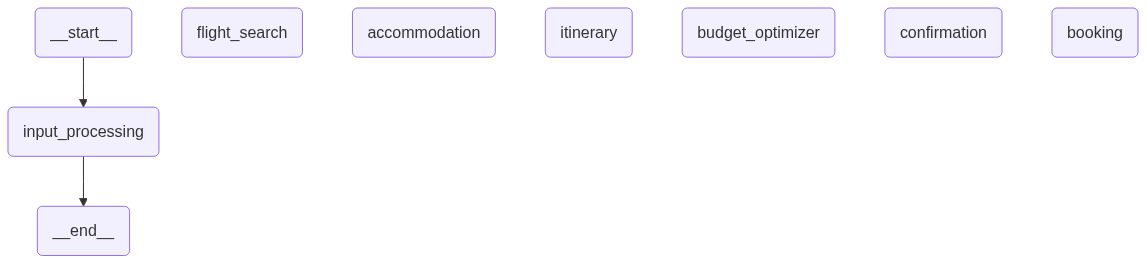

🎯 Planning trip: New York, NY → Paris, France
   Duration: 7 days | Budget: $4,000.0 | Travelers: 2

 Starting travel planning process...

🌍 TRAVEL PLAN SUMMARY
📍 Trip Details:
   From: New York, NY
   To: Paris, France
   Travelers: 2
   Duration: 7 days
   Start Date: 2024-06-15
   Budget: $4,000.00

💰 Cost Breakdown:
   Total Cost: $3,380.00
   Flights: $1,280.00
   Accommodation: $1,400.00
   Activities_Food: $700.00

✈️ Flight Options:
   Outbound: 2 options available
     1. Delta Airlines - $350/person - 4h 0m
     2. American Airlines - $320/person - 4h 0m
   Return: 2 options available

🏨 Accommodation Options:
   1. Hotel Le 123 Sébastopol - Astotel - $200/night - 4.5⭐
      Location: 2nd Arrondissement
      Amenities: free wifi, bar, breakfast included, 24-hour front desk
   2. Hôtel Fabric - $210/night - 4.7⭐
      Location: 11th Arrondissement
      Amenities: free wifi, gym, bar, breakfast available
   3. Le Marais – Havre de Paix - $250/night - 4.3⭐
      Location: Le M

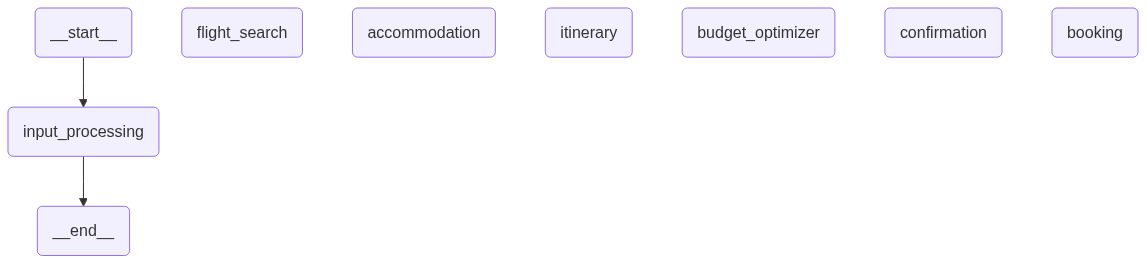


🌍 TRAVEL PLAN SUMMARY
📍 Trip Details:
   From: Bengaluru
   To: New Delhi
   Travelers: 2
   Duration: 5 days
   Start Date: 2025-10-01
   Budget: $1,000.00

💰 Cost Breakdown:
   Total Cost: $2,180.00
   Flights: $1,280.00
   Accommodation: $400.00
   Activities_Food: $500.00

✈️ Flight Options:
   Outbound: 2 options available
     1. Delta Airlines - $350/person - 4h 0m
     2. American Airlines - $320/person - 4h 0m
   Return: 2 options available

🏨 Accommodation Options:
   1. Grand Plaza Hotel - $120/night - 4.2⭐
      Location: Downtown
      Amenities: WiFi, Pool, Gym
   2. Budget Inn - $80/night - 3.5⭐
      Location: City Center
      Amenities: WiFi, Breakfast

📅 Daily Itinerary:
   Day 1 (2025-10-01):
     Activities: Activity 1, Sightseeing 1
     Meals: Local Cafe, Popular Restaurant, Street Food
     Estimated Cost: $100
   Day 2 (2025-10-02):
     Activities: Activity 2, Sightseeing 2
     Meals: Local Cafe, Popular Restaurant, Street Food
     Estimated Cost: $100
   D

In [16]:
if __name__ == "__main__":
    # Run main demo
    main()
    
    # Ask if user wants to try custom input
    print(f"\n{'='*50}")
    try:
        custom_demo = input("🎯 Would you like to try with your own travel details? (y/n): ").strip().lower()
        if custom_demo in ['y', 'yes']:
            demo_with_custom_input()
        else:
            print("Thank you for trying the Travel Planner Demo!")
    except KeyboardInterrupt:
        print("\n\n Goodbye!")
    except Exception:
        print(" Thank you for trying the Travel Planner Demo!")